## 首先， BERT 很耗時，要先

執行階段 -> 變更執行類型 -> 開啟GPU開啟GPU

看完這篇再去調參數:
https://mlfromscratch.com/activation-functions-explained/#/

In [1]:
# !kill the RAM
# !kill -9 -1

## 此檔案用Leo iss帳號 執行，因為GPU不足

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## 先確定確認環境是否支援GPU 

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# ### 為 pytorch 設定使用 GPU 
# 沒關係，我們用CPU跑torch
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('有 %d 個 GPU 可使用。' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('沒有 GPU 可使用，改使用 CPU。')
    device = torch.device("cpu")

有 1 個 GPU 可使用。
GPU: Tesla T4


## 沒開GPU/沒GPU用/GPU 扣打用完，下面train data改小一點，不然會等到畢業

In [5]:
!pip install -q -U "tensorflow-text==2.8.*" #  # 安裝指定版本，不然colab會裝最新版，如果之後沒有向下支援會不能跑

     |████████████████████████████████| 4.9 MB 10.4 MB/s 


用AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [6]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 352 kB 50.9 MB/s 
     |████████████████████████████████| 99 kB 10.6 MB/s 
     |████████████████████████████████| 237 kB 66.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.6 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.9 MB/s 
     |████████████████████████████████| 92 kB 7.3 MB/s 


In [7]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## 直接指定中文的預先處理程序(pre-process)
- ps: 要其他的版本去另一個ipynb找，我有寫一個可以抓版本的介面

## Key的七個秘密:


1.   input_mask: 輸入的mask，1代表是正常輸入，0代表的是padding的輸入
2.   segment_ids: 輸入的0：代表句子A或者padding句子，1代表句子B
3.   masked_lm_positions：我們mask的token的位置
4. masked_lm_ids：我們mask的token的對應id
5. masked_lm_weights：我們mask的token的權重，1代表是真實mask的，0代表的是padding的mask
6. next_sentence_labels：句子A和B是否是上下句 (這個新的Paper指出很廢，沒啥用)
7. input_ids: 輸入的token對應的id

Test1

In [8]:
tfhub_handle_preprocess = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# text_test = ['他只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']
text_test = ['我只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']

text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}') # Keys對應了七個屬性，這邊列印出來跟classification有關的，其他四個屬性我沒用過，要查Hub裡面的Advance topics
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}') # 最大長度，我們這個模型最多吃128 -3 = 125個長度的句子
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # [101] 是 [CLS]
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}') # 1就是有字，0是我們padding 的0
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}') # 不知道這是洨

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [ 101 2769 1372 3221  943 2111 2094 1557  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Test2

In [9]:
text_test = ['他只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']
#text_test = ['我只是個孩子啊','我的心碎成了很多片，每一片都扎在你的腳底']

text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}') # Keys對應了七個屬性，這邊列印出來跟classification有關的，其他四個屬性我沒用過，要查Hub裡面的Advance topics
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}') # 最大長度，我們這個模型最多吃128 -3 = 125個長度的句子
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # [101] 是 [CLS] [102]是[SEP]
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [ 101  800 1372 3221  943 2111 2094 1557  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## 直接指定中文的encoder

bert_zh_L-12_H-768_A-12

看檔名: 768維度，所以我們不是用large(1024還是1048維度)的

In [10]:
tfhub_handle_encoder = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

print(f'\n\n-----------------Sequence Outputs 【batch_size, seq_length, hidden_size】:\n\n')

# 這是訓練後每個token的詞向量。
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')

print(f'\n\n-----------------Pooled_output 【batch_size, hidden_size】:\n\n')
# 每個sequence第一個位置CLS的向量輸出，用於分類任務。
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['pooled_output', 'encoder_outputs', 'sequence_output', 'default']
Pooled Outputs Shape:(2, 768)
Pooled Outputs Values:[ 0.9951877   0.9999987   0.75895447  0.9927028   0.9609237   0.8980626
 -0.9664992  -0.8147569   0.992256   -0.9955092   0.9999951  -0.03696701]


-----------------Sequence Outputs 【batch_size, seq_length, hidden_size】:


Sequence Outputs Shape:(2, 128, 768)


-----------------Pooled_output 【batch_size, hidden_size】:


Sequence Outputs Values:[[ 0.26301262  0.59707963  0.22219351 ...  1.0153513   0.13897443
  -0.00661813]
 [ 1.2074199   0.61525524  0.7530454  ...  0.1953829   0.26875502
   0.606423  ]
 [ 1.285511   -0.06451766  0.01800819 ...  0.81091714  0.5056504
   0.21488908]
 ...
 [ 0.3440423   0.73617125 -0.01728487 ... -0.06457531 -0.53578055
  -0.10931359]
 [ 0.28242332  0.7280945  -0.0751037  ...  0.00773475 -0.59589773
  -0.18359847]
 [ 0.1683045   0.5671126  -0.10745365 ...  0.06260364 -0.69228685
  -0.15895809]]


# 環境準備

In [11]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

import tensorflow as tf
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

## encoder 和 preprocess指定

In [12]:
tfhub_handle_preprocess = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
tfhub_handle_encoder = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## 準備資料集

因為是在Colab上傳檔案的形式。所以在本地壓縮成一個zip包,上傳到Colab後做解壓。

(因為我只找得到簡體的有label的情緒分資料，這邊應該換成繁體的)
我這邊用https://github.com/lunarwhite/Chinese-corpus-sentiment-data-analysis
的資料集，zip檔有上傳到資料夾了

In [13]:
import zipfile
from pathlib import Path
# zipfile_path = "/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/Code/Leo's workplace/data source/datanew.zip" 
# zipfile_path = "/content/drive/MyDrive/Text Mining Team Project/Code/Leo's workplace/data source/datanew.zip" 
zipfile_path = "/content/drive/Shareddrives/Text Mining/DataSource/datanew.zip"
zFile = zipfile.ZipFile(zipfile_path ,"r")
for fileM in zFile.namelist(): 
        zFile.extract(fileM, "datanew")
# zFile.close();

## 把Tuning 的參數拉出來設定

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 110078509

拆出Train data

In [15]:
datanew_path = "/content/datanew/datanew"

In [16]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    datanew_path,
    batch_size=batch_size,
    validation_split=0.2, # 從pos, neg中取出80% 當成train data
    subset='training',
    seed=seed)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.


In [17]:
class_names = raw_train_ds.class_names
print(class_names) # ['neg', 'pos']
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE) # 邊拉檔案邊跑模型，不用等全部載完才跑

['neg', 'pos']


In [18]:
# val_ds = tf.keras.utils.text_dataset_from_directory(
#     'aclImdb/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='validation',
#     seed=seed)

# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_ds = tf.keras.utils.text_dataset_from_directory(
#     'aclImdb/test',
#     batch_size=batch_size)

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Validation set

In [19]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    datanew_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
## 問題: 為何不會拉到training data? 可4Google turtrial都這樣寫捏

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # Same, we work smart

Found 4000 files belonging to 2 classes.
Using 800 files for validation.


## dataset 長這副德性


In [20]:
for text_batch, label_batch in train_ds.take(1):
  # print(text_batch)
  for i in range(3):
    # print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    # print(f'Label : {label} ({class_names[label]})')

## Define Model

### tf.layers.dense()

- inputs：輸入該網絡層的數據
- activation：激活函數，即神經網絡的非線性變化，用sigmoid
  - Sigmoid:
  1. 有梯度消失問題
  2. 值在0-1間
  3. 收斂有夠慢

優化器選擇adamw: 

- Why: 用adamw的原因是要強化收斂速度，但是要調參。
- What: 權重衰減與 L2 正則化(減少overfitting)

- 可以用SGD+ Momentum 取代
- 為何不用gelu?

參考: https://zhuanlan.zhihu.com/p/39543160

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)

  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)  
  # 改成softmax邏輯回歸比較好，這樣最後一層的機率總和才會是1 來取出非互斥類別0/1值
  # 搭配softmax必須使用Cross Entropy當loss function
  return tf.keras.Model(text_input, net)
classifier_model = build_classifier_model()

# Fine-Tuning
# BERT原先pretrained的優化器是adamw
# This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.
# learning rate (init_lr)採用BERT pre-training: linear decay of a notional initial learning rate, num_warmup_steps = 0.1
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                      num_train_steps=num_train_steps,
                      num_warmup_steps=num_warmup_steps,
                      optimizer_type='adamw') 


# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy() # 原本
# 搭配softmax必須使用Cross Entropy當loss function: 評估兩個機率分配(distribution) 有多接近，越遠entrophy 越靠近1


metrics = tf.metrics.SparseCategoricalAccuracy()# 原本
# metrics = tf.metrics.BinaryAccuracy()


#訓練模型Model Training : Loading the BERT model and training
classifier_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)



history = classifier_model.fit(x=train_ds,
                 validation_data=val_ds,
                 epochs=epochs)

1000
Epoch 1/10
100/100 [==============================] - 138s 1s/step - loss: 1.1270 - sparse_categorical_accuracy: 0.6275 - val_loss: 0.3121 - val_sparse_categorical_accuracy: 0.8988
Epoch 2/10
100/100 [==============================] - 100s 1s/step - loss: 0.3030 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.2897 - val_sparse_categorical_accuracy: 0.8963
Epoch 3/10
100/100 [==============================] - 101s 1s/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.3854 - val_sparse_categorical_accuracy: 0.8888
Epoch 4/10
100/100 [==============================] - 101s 1s/step - loss: 0.1485 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.5155 - val_sparse_categorical_accuracy: 0.8963
Epoch 5/10
100/100 [==============================] - 100s 1s/step - loss: 0.0869 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.4756 - val_sparse_categorical_accuracy: 0.9075
Epoch 6/10
100/100 [==============================] - 98s 985ms/step - loss: 0.0269 - spar

History 資料儲存
該資料為model

In [22]:
# 存成csv
# model_path = "/content/drive/Shareddrives/Text Mining/DataSource/bertmodel_parameter/"
# hist_csv_file = 'history.csv'
# with open(model_path + 'history.csv', mode='w') as f:
#     history.to_csv(f)

## 存model起來，不然每次都要訓練，GPU不夠

In [23]:
#!pip install h5py

Load in the model

In [24]:
# # 從 HDF5 檔案中載入模型
# model_pwd = "/content/drive/Shareddrives/Text Mining/DataSource/bertmodel_parameter/history.csv"
# model = tf.contrib.keras.models.load_model(model_pwd)

# # # # 驗證模型
# # score = model.evaluate(x_test, y_test, verbose=0)

# # # 輸出結果
# # print('Test loss:', score[0])
# # print('Test accuracy:', score[1])

## 預測資料

In [25]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : class: {class_names[np.argmax(results[i])] }'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

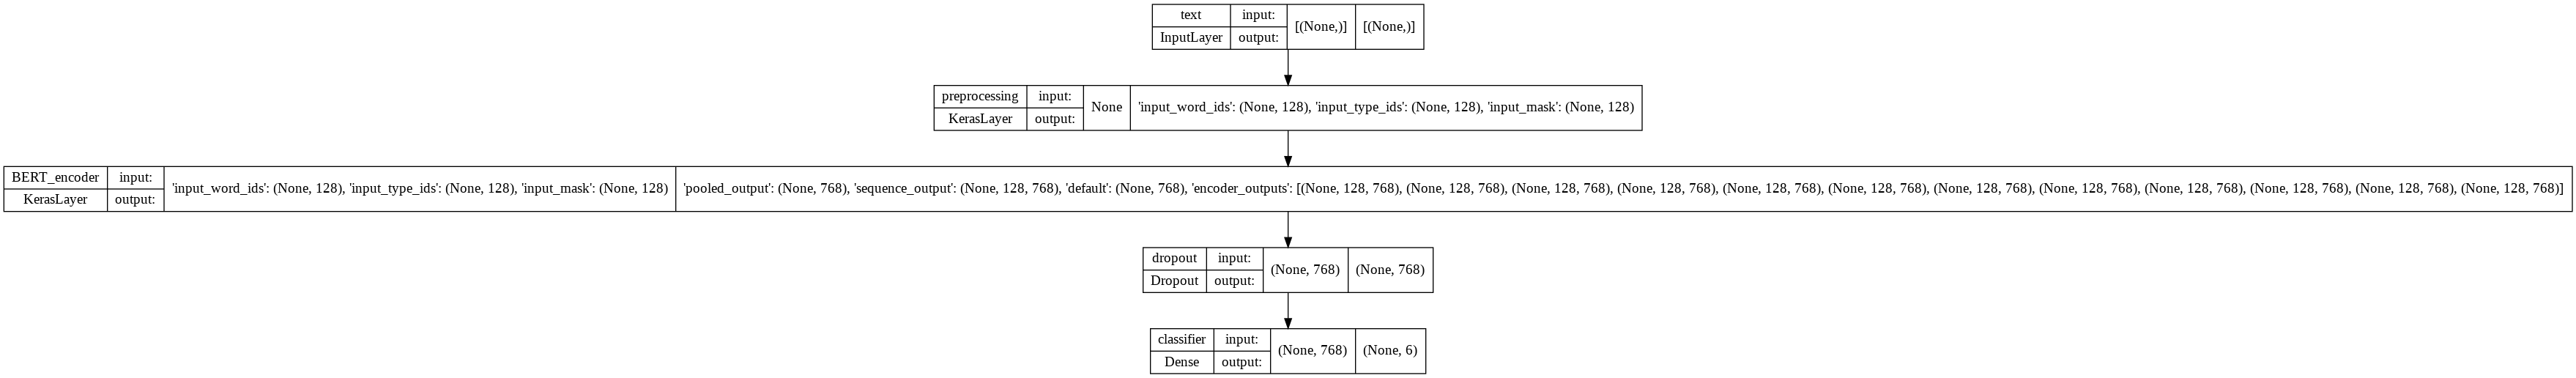

In [26]:
tf.keras.utils.plot_model(classifier_model, "mini_resnet.png", show_shapes=True)

Import the title as df

In [27]:
# import_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Crawler/'
import_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Summary/Stage1/'

# GUO
input_GUO = pd.read_csv(import_pwd +'All_GUO.csv')
titile_csv = input_GUO



In [68]:
def BertResult_mix(titile_csv,filename, save_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Summary/Stage2/'):
  # 將title+content的欄位與title欄位分別進行預測，加入dataframe中並寫入folder存入folder
  # Newest_EDITION
  title1,result_for_pred1 = inner_predict(titile_csv,'limited_Bert')
  title2,result_for_pred2 = inner_predict(titile_csv,'title')
  # Extraction
  titile_csv['mix_predict'] = result_for_pred1
  titile_csv['title_predict'] = result_for_pred2
  # print(tf.sigmoid(predictiion))
  titile_csv.drop(columns=titile_csv.columns[0], axis=1, inplace=True)
  # Save path
  path = save_pwd + str(filename)
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    titile_csv.to_csv(f,index=False)

def inner_predict(df, column_name):
  text_list = df[column_name]
  title = [f'{text_list[i]:<123}'for i in range(len(text_list))]
  prediction = classifier_model(tf.constant(text_list))
  result_for_pred = [f'{class_names[np.argmax(prediction[i])] }' for i in range(len(prediction))]
  return title, result_for_pred

Used_code



```
def BertResult_title(titile_csv,filename):
    #generate the predictive result 
    #text_list = titile_csv.columns
    text_list = titile_csv['title']
    predictiion = classifier_model(tf.constant(text_list))

    # Extraction
    result_for_pred = [f'{class_names[np.argmax(predictiion[i])] }' for i in range(len(predictiion))]
    title = [f'{text_list[i]:<30}'for i in range(len(text_list))]
    pred = pd.DataFrame({"title":title, "predict": result_for_pred})

    # Save path
    default_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Title_pos_neg/'
    path = default_pwd + str(filename)
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      pred.to_csv(f)
```




```
def BertResult_content(content_csv,filename):
  # 需要更改
  #generate the predictive result 
  text_list = content_csv.columns
  predictiion = classifier_model(tf.constant(text_list))

  # Extraction
  result_for_pred = [f'{class_names[np.argmax(predictiion[i])] }' for i in range(len(predictiion))]
  title = [f'{text_list[i]:<30}'for i in range(len(text_list))]
  pred = pd.DataFrame({"title":title, "predict": result_for_pred})
  # save path
  default_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Content_pos_neg/'
  path = default_pwd + str(filename)
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    pred.to_csv(f)
```




### Prediction 

In [69]:
import_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Summary/Stage1/'
export_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Summary/Stage2/'

# # GUO
name = "Mix_GUO.csv"
input_GUO = pd.read_csv(import_pwd +'All_GUO.csv')
BertResult_mix(input_GUO,filename = name, save_pwd= export_pwd)

# LEE
name = "Mix_LEE.csv"
input_LEE = pd.read_csv(import_pwd + 'All_LEE.csv')
BertResult_mix(input_LEE,filename = name)

# LIN
name = "Mix_LIN.csv"
input_LIN = pd.read_csv(import_pwd + 'All_LIN.csv')
BertResult_mix(input_LIN,filename = name)

# TAI
name = "Mix_TAI.csv"
input_TAI = pd.read_csv(import_pwd + 'All_TAI.csv')
BertResult_mix(input_TAI,filename = name)

# YANG
name = "Mix_YANG.csv"
input_YANG = pd.read_csv(import_pwd + 'All_YANG.csv')
BertResult_mix(input_YANG,filename = name)

#### 合併title 資料

此段程式碼是用於產出將BERT五位運動員之預測資料合併成一份CSV資料合併成一份CSV

In [72]:
import os

# 要拼接的文件夾及其完整路徑，注不要包含中文
## 待讀取批量csv的文件夾
read_folder =  export_pwd
# 修改當前工作目錄
os.chdir(read_folder)
# 將該文件夾下的所有文件名存入列表
csv_name_list = os.listdir()

data_df = pd.DataFrame()
for i in range(len(csv_name_list)):
  # 讀取第一個CSV文件幷包含表頭，用於後續的csv文件拼接
  df = pd.read_csv( csv_name_list[i],header=None) #不把第一行作列屬性 
  print(f'Current finish the {i}; Name: {csv_name_list[i]} \n')

  print("Let's rbind")
  
  data_df = data_df.append(df)


# drop the index 
data_df = data_df.drop(columns=[0])
# reset the column name
#data_df.columns = ['index1', 'index2','Title', 'Content', 'Mix', 'Mix_prediction', 'Title_Prediction']


new_header = data_df.iloc[0] #grab the first row for the header
df = data_df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

# save as csv
write_folder = "/content/drive/Shareddrives/Text Mining/CSV/Summary/"
path = write_folder + "mix_all_athelete.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f, index = False)
df.head(10)

Current finish the 0; Name: Mix_LEE.csv 

Let's rbind
Current finish the 1; Name: Mix_LIN.csv 

Let's rbind
Current finish the 2; Name: Mix_TAI.csv 

Let's rbind
Current finish the 3; Name: Mix_YANG.csv 

Let's rbind
Current finish the 4; Name: Mix_GUO.csv 

Let's rbind


,category,title,content,limited_Bert,mix_predict,title_predict
1,新聞,李智凱秀妻子送他歲生日豪禮要當爸,三立李鴻典台北報導恭喜李智凱秀妻子送他歲生日豪禮要當爸爸了完整新聞內文恭喜再恭喜歲體操國手鞍...,李智凱秀妻子送他歲生日豪禮要當爸:三立李鴻典台北報導恭喜李智凱秀妻子送他歲生日豪禮要當爸爸了...,pos,pos
2,新聞,台灣首位世界第「鞍馬王子」李智凱,林岳甫台灣首位世界第「鞍馬王子」李智凱我會繼續努力完整新聞內文在東京奧運勇奪鞍馬銀牌，為台灣...,台灣首位世界第「鞍馬王子」李智凱:林岳甫台灣首位世界第「鞍馬王子」李智凱我會繼續努力完整新聞...,pos,pos
3,新聞,李智凱登鞍馬世界第恩師林育信報喜,游郁香李智凱登鞍馬世界第恩師林育信報喜希望鼓勵小選手追夢完整新聞內文「鞍馬王子」李智凱以招牌...,李智凱登鞍馬世界第恩師林育信報喜:游郁香李智凱登鞍馬世界第恩師林育信報喜希望鼓勵小選手追夢完...,pos,pos
4,問卦,台灣李智凱奧運體操為什麼能贏歐美中國,歐美中國算是體操大國，歐美中國也投資很多資源在體操為什麼在台灣培訓，被台灣教練訓練李智凱能夠...,台灣李智凱奧運體操為什麼能贏歐美中國:歐美中國算是體操大國，歐美中國也投資很多資源在體操為什...,pos,pos
5,問卦,李智凱敢挑戰街健嗎,街健肌肉應用最高形式完美控制身體藝術相比之下體操簡直是平淡創意卻企圖以華麗表演來掩飾李智凱雖...,李智凱敢挑戰街健嗎:街健肌肉應用最高形式完美控制身體藝術相比之下體操簡直是平淡創意卻企圖以華...,pos,pos
6,問卦,李智凱沒拍過武打片?,李智凱好像是上屆奧運就很有名選手他顏值和身手尤其是掃堂腿應該很適合拍武打功夫片吧怎麼沒成為男主?,李智凱沒拍過武打片?:李智凱好像是上屆奧運就很有名選手他顏值和身手尤其是掃堂腿應該很適合拍武...,pos,neg
7,問卦,中國體操鞍馬培養不出台灣李智凱等級選手,最近覺青真蠻好笑中國拿銀作圖嘲笑中國拿銀牌，洗版整天中國拿金，金牌數第一關我屁事，他國事務這...,中國體操鞍馬培養不出台灣李智凱等級選手:最近覺青真蠻好笑中國拿銀作圖嘲笑中國拿銀牌，洗版整天...,neg,neg
8,問卦,中國體操鞍馬培養不出台灣李智凱等級選手,引述綠營重新執政之銘言中國不是算體操大國嗎為什麼李智凱能大勝中國鞍馬參賽者李智凱拿鞍馬銀牌，...,中國體操鞍馬培養不出台灣李智凱等級選手:引述綠營重新執政之銘言中國不是算體操大國嗎為什麼李智...,neg,neg
9,問卦,中國體操鞍馬培養不出台灣李智凱等級選手,中國不是算體操大國嗎為什麼李智凱能大勝中國鞍馬參賽者李智凱拿鞍馬銀牌，中國選手連銅牌都沒有為...,中國體操鞍馬培養不出台灣李智凱等級選手:中國不是算體操大國嗎為什麼李智凱能大勝中國鞍馬參賽者...,neg,neg
10,新聞,李智凱完美落地摘銀謝長廷謝謝他實現,他不是第一次提到奧運是他夢想這件事了而是三不五時遇到選手就會把這件事情拿出來說一下對奧運真很...,李智凱完美落地摘銀謝長廷謝謝他實現:他不是第一次提到奧運是他夢想這件事了而是三不五時遇到選手...,pos,pos


## 純文字檔test

In [36]:
# text_1 = ["黑人老兄受不了老媽一直偷吃他的雞肉，拿起光劍去找老媽輸贏"]
# example_result = classifier_model(tf.constant(text_1))

# print_my_examples(text_1,example_result)